In [2]:
!pip install pandas==1.3.4
!pip install scikit-learn==1.0.2
!pip install numpy==1.21.6
!pip install pyspark==3.1.2 -q
!pip install findspark -q
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 62.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.17.0 requires pandas>=1.4.0, but you have pandas 1.3.4 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.0.11 which is incompatible.
esda 2.5.1 requires pandas>1.4, but you have pandas 1.3.4 which is incompatible.
featuretools 1.28.0 requires pandas>=1.5.0, but you have pandas 1.3.4 which is incompatible.
geopandas 0.14.2 requires pandas>=1.4.0, but you have pandas 1.3.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires pa

In [3]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# FindSpark simplifies the process of using Apache Spark with Python

import findspark
findspark.init()

#import functions/Classes for sparkml

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession


# import functions/Classes for pipeline creation
from pyspark.ml import Pipeline

# import functions/Classes for metrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from sklearn.linear_model import LinearRegression

In [5]:
#Create SparkSession
#Ignore any warnings by SparkSession command

spark = SparkSession.builder.appName("Regression using SparkML").getOrCreate()

24/02/27 15:25:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
URL = "/kaggle/input/moscow-housing-price-dataset/data.csv"

In [7]:
df = spark.read.csv(URL, header=True, inferSchema=True)

In [8]:
df.printSchema()

root
 |-- Price: double (nullable = true)
 |-- Apartment type: string (nullable = true)
 |-- Metro station: string (nullable = true)
 |-- Minutes to metro: double (nullable = true)
 |-- Region: string (nullable = true)
 |-- Number of rooms: double (nullable = true)
 |-- Area: double (nullable = true)
 |-- Living area: double (nullable = true)
 |-- Kitchen area: double (nullable = true)
 |-- Floor: double (nullable = true)
 |-- Number of floors: integer (nullable = true)
 |-- Renovation: string (nullable = true)



In [9]:
df.show(5)

+---------+--------------+-------------+----------------+-------------+---------------+----+-----------+------------+-----+----------------+--------------------+
|    Price|Apartment type|Metro station|Minutes to metro|       Region|Number of rooms|Area|Living area|Kitchen area|Floor|Number of floors|          Renovation|
+---------+--------------+-------------+----------------+-------------+---------------+----+-----------+------------+-----+----------------+--------------------+
|6300000.0|     Secondary|      Опалиха|             6.0|Moscow region|            1.0|30.6|       11.1|         8.5| 25.0|              25|            Cosmetic|
|9000000.0|     Secondary|      Павшино|             2.0|Moscow region|            1.0|49.2|       20.0|        10.0|  6.0|              15|European-style re...|
|  1.109E7|     Secondary|     Мякинино|            14.0|Moscow region|            1.0|44.7|       16.2|        13.1| 10.0|              25|            Cosmetic|
|8300000.0|     Secondary|  

In [10]:
df.describe().show()

+-------+-------------------+--------------+-------------+-----------------+-------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+
|summary|              Price|Apartment type|Metro station| Minutes to metro|       Region|   Number of rooms|             Area|       Living area|      Kitchen area|            Floor| Number of floors|        Renovation|
+-------+-------------------+--------------+-------------+-----------------+-------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+
|  count|              22676|         22676|        22676|            22676|        22676|             22676|            22676|             22676|             22676|            22676|            22676|             22676|
|   mean|3.612132181531134E7|          null|         null|11.88860469218557|         null|2.0431292997001234|71.9668

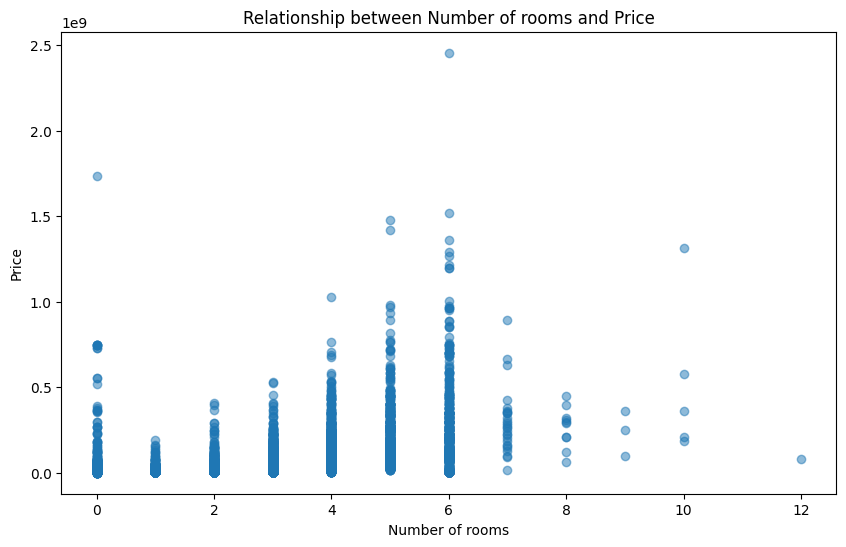

In [11]:
# Plot the relationship using matplotlib
pandas_df = df.select("Number of rooms", "Price").toPandas()
    
# Plot the relationship using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["Number of rooms"], pandas_df["Price"], alpha=0.5)
plt.title("Relationship between Number of rooms and Price")
plt.xlabel("Number of rooms")
plt.ylabel("Price")
plt.show()

In [12]:
spark.version

'3.1.2'

In [13]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.linalg import Vectors

In [14]:
# Define the categorical columns
categorical_cols = ["Apartment type", "Metro station", "Region", "Renovation"]

# Create StringIndexers for categorical columns with error handling
indexers = [
    StringIndexer(
        inputCol=col,
        outputCol=f"{col}_index",
        handleInvalid="keep"  # Maintain invalid string values for further treatment
    )
    for col in categorical_cols
]

# Modified OneHotEncoders to use unique output column names
encoders = [
    OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_onehot")
    for col in categorical_cols
]


In [15]:
# Define the numerical columns (assuming Kitchen area is numeric)
numerical_cols = ["Minutes to metro", "Number of rooms", "Area", "Living area", "Kitchen area", "Floor", "Number of floors"]

# Create a VectorAssembler for numerical features
assembler_numerical = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")

# Create a VectorAssembler for the one-hot encoded categories and missing value placeholder
assembler_categorical = VectorAssembler(
    inputCols=[f"{col}_onehot" for col in categorical_cols] ,
    outputCol="categorical_features"
)

# Create a VectorAssembler for both numerical and categorical features
assembler = VectorAssembler(
    inputCols=["numerical_features", "categorical_features"],
    outputCol="features"
)

In [30]:
# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Price")
# Create a Pipeline to execute the transformations in order
pipeline = Pipeline(stages=indexers + encoders + [assembler_numerical, assembler_categorical, assembler, lr])


TypeError: LinearRegression.__init__() got an unexpected keyword argument 'featuresCol'

In [17]:
    # Split the data into training and testing sets
    (training_data, testing_data) = df.randomSplit([0.7, 0.3], seed=42)

In [26]:
# Fit the pipeline to the training data
fitted_train = pipeline.fit(training_data)
transformed_train = fitted_pipeline.transform(training_data)  # Show transformed data
transformed_train.show()

+---------+--------------+-----------------+----------------+-------------+---------------+-----+-----------+------------+-----+----------------+------------------+--------------------+-------------------+------------+----------------+---------------------+--------------------+-------------+-----------------+--------------------+--------------------+--------------------+
|    Price|Apartment type|    Metro station|Minutes to metro|       Region|Number of rooms| Area|Living area|Kitchen area|Floor|Number of floors|        Renovation|Apartment type_index|Metro station_index|Region_index|Renovation_index|Apartment type_onehot|Metro station_onehot|Region_onehot|Renovation_onehot|  numerical_features|categorical_features|            features|
+---------+--------------+-----------------+----------------+-------------+---------------+-----+-----------+------------+-----+----------------+------------------+--------------------+-------------------+------------+----------------+-----------------

In [28]:
fitted_train = pipeline.fit(testing_data)
transformed_test = fitted_pipeline.transform(testing_data)  # Show transformed testing data
transformed_test.show()

+---------+--------------+-----------------+----------------+-------------+---------------+-----+-----------+------------+-----+----------------+------------------+--------------------+-------------------+------------+----------------+---------------------+--------------------+-------------+-----------------+--------------------+--------------------+--------------------+
|    Price|Apartment type|    Metro station|Minutes to metro|       Region|Number of rooms| Area|Living area|Kitchen area|Floor|Number of floors|        Renovation|Apartment type_index|Metro station_index|Region_index|Renovation_index|Apartment type_onehot|Metro station_onehot|Region_onehot|Renovation_onehot|  numerical_features|categorical_features|            features|
+---------+--------------+-----------------+----------------+-------------+---------------+-----+-----------+------------+-----+----------------+------------------+--------------------+-------------------+------------+----------------+-----------------

In [29]:
# Select only relevant columns (features and target)
selected_cols = ["features", "Price"]
final_df = df.select(selected_cols)

AnalysisException: cannot resolve '`features`' given input columns: [Apartment type, Area, Floor, Kitchen area, Living area, Metro station, Minutes to metro, Number of floors, Number of rooms, Price, Region, Renovation];
'Project ['features, Price#16]
+- Relation[Price#16,Apartment type#17,Metro station#18,Minutes to metro#19,Region#20,Number of rooms#21,Area#22,Living area#23,Kitchen area#24,Floor#25,Number of floors#26,Renovation#27] csv


In [ ]:

    # Fit the pipeline to the training data
    model = final_df.fit(training_data)

df.plot.scatter(x="

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Assuming your features column is named 'features' and the label column is 'Price'
lr = LinearRegression(featuresCol="features", labelCol="Price")

# Fit the modelaef
    model = lr.fit(training_data)


In [ ]:
# Make predictions on testing data
predictions = model.transform(testing_data)

In [ ]:
from pyspark.sql.functions import col, count, when

# Assuming your Spark DataFrame is named 'df'
empty_counts = df.select([count(when(col(c).isNull() | (col(c) == ""), c)).alias(c) for c in df.columns])

# Show the empty entry counts
empty_counts.show()


In [ ]:
#R-squared (R2): R2 is a statistical measure that represents the proportion of variance
#in the dependent variable (target) that is explained by the independent variables (features).
#Higher values indicate better performance.

evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R Squared =", r2)

In [ ]:
#Root Mean Squared Error (RMSE): RMSE is the square root of the average of the squared differences
#between the predicted and actual values. It measures the average distance between the predicted
#and actual values, and lower values indicate better performance.

evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE =", rmse)


In [ ]:
#Mean Absolute Error (MAE): MAE is the average of the absolute differences between the predicted and
#actual values. It measures the average absolute distance between the predicted and actual values, and
#lower values indicate better performance.

evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE =", mae)
